
=== Rolling Day 2024-12-01 ===
  train_cutoff=2024-07-01  val_cutoff=2024-11-30
  Forecast next 30 days from 2024-12-01 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-01_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-01_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-01_V1.pt
[PyTorch] Loading CNN from ./best_CNN_2024-12-01_V1.pt
[PyTorch] Loading Transformer from ./best_Transformer_2024-12-01_V1.pt
[PyTorch] Loading N-BEATS from ./best_N-BEATS_2024-12-01_V1.pt
[PyTorch] Loading N-HITS from ./best_N-HITS_2024-12-01_V1.pt
[sklearn] Loading SVM => ./best_SVM_2024-12-01_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2024-12-01_V1.pkl

=== Rolling Day 2024-12-02 ===
  train_cutoff=2024-07-02  val_cutoff=2024-12-01
  Forecast next 30 days from 2024-12-02 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-02_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-02_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-02_V1.pt
[PyTor

/tmp/ipykernel_787989/4258335625.py:385: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
/tmp/ipykernel_787989/4258335625.py:404: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()


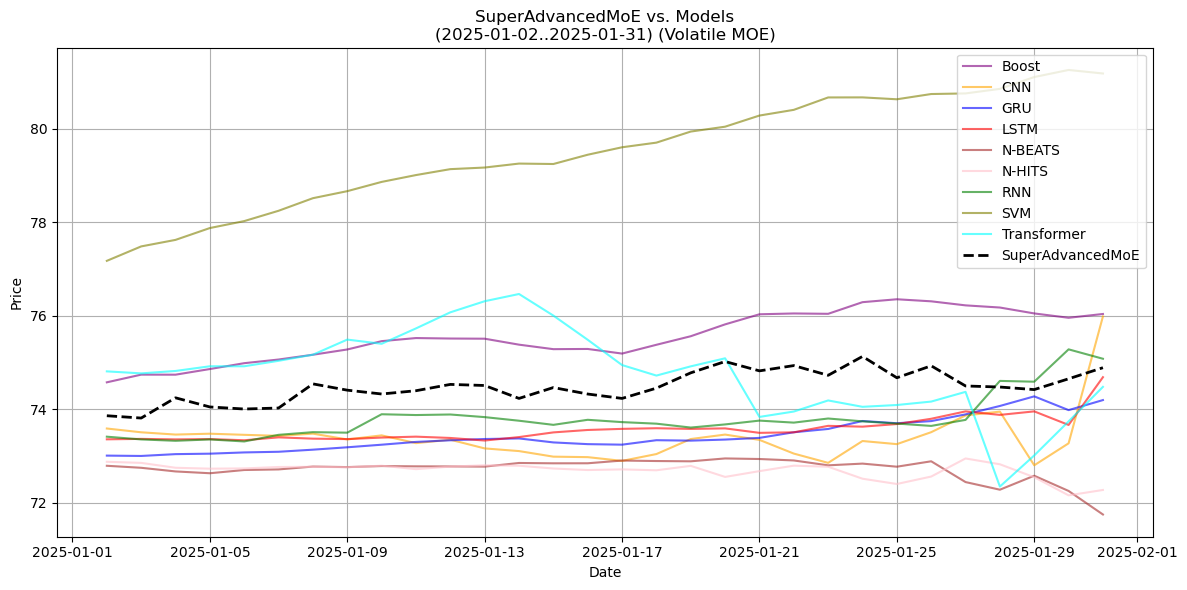

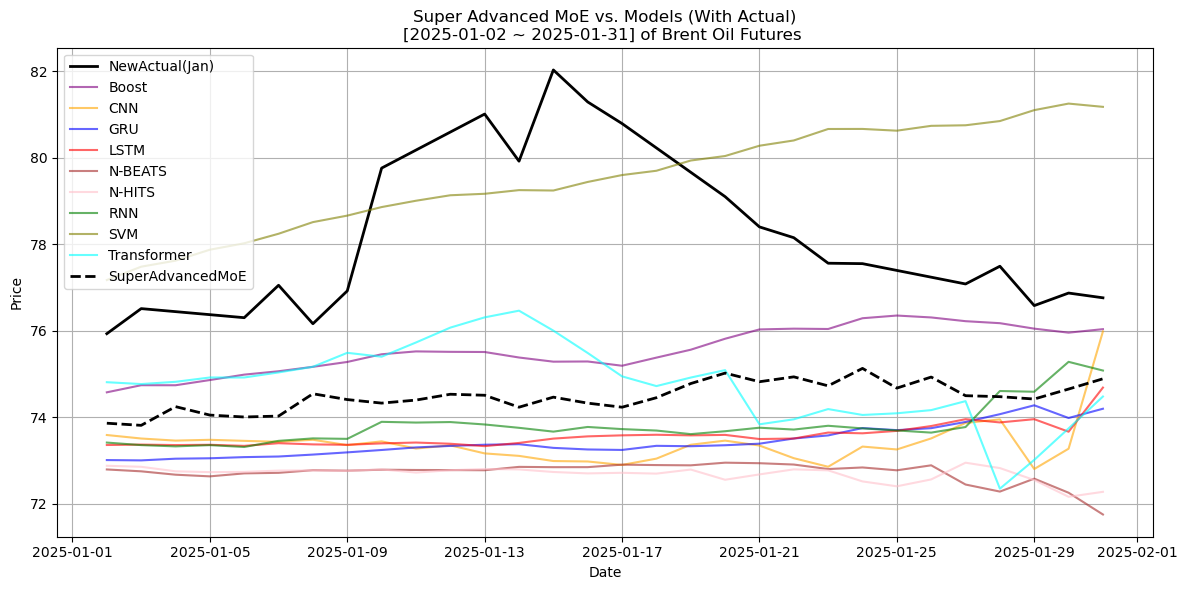

/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.

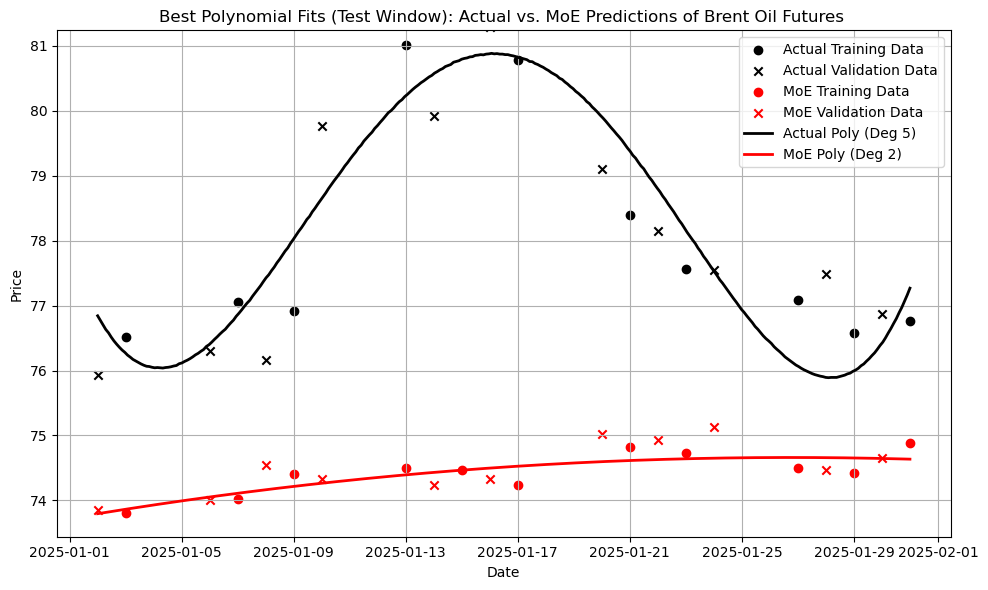


=== Best Polynomial Fitting Results ===
[Actual] => Degree=5, Val MSE=0.732527
     y = 5.9483e-09*x^5-3.5905e-04*x^4+4.8319e+00*x^3+9.5959e+04*x^2-2.9056e+09*x+1.9488e+13

[MoE] => Degree=2, Val MSE=0.068546
     y = -1.4146e-03*x^2+5.6908e+01*x-5.7227e+05

=== Derivative for Actual (Degree 5 => 4) ===
   d/dx of Actual = 2.9742e-08*x^4-1.4362e-03*x^3+1.4496e+01*x^2+1.9192e+05*x-2.9056e+09

=== Derivative for MoE (Degree 2 => 1) ===
   d/dx of MoE = -2.8292e-03*x+5.6908e+01



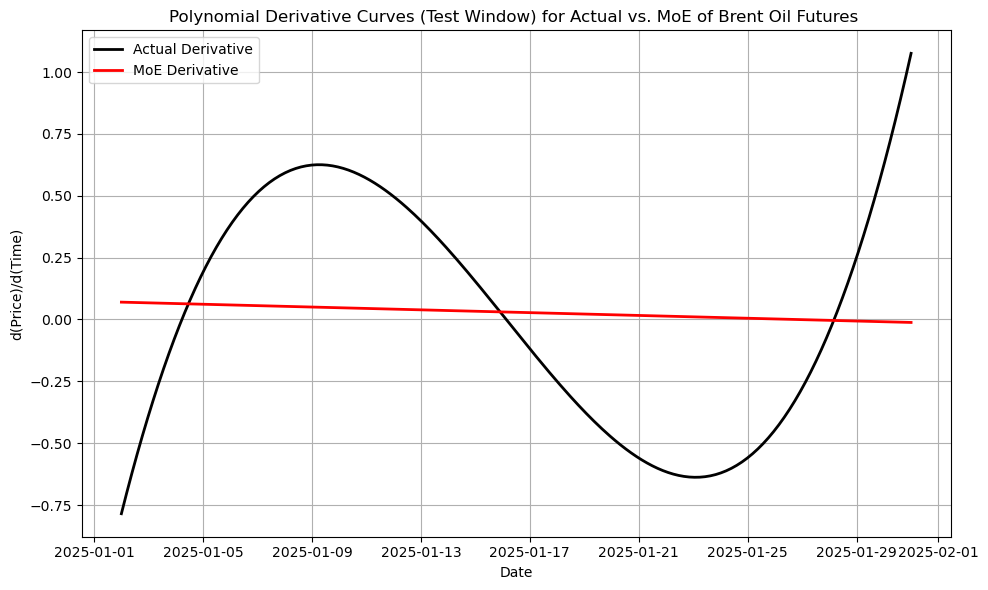


All done with MoE + polynomial fittings for both Actual and MoE!


In [1]:
####################################################
# SUPER ADVANCED MOE SCRIPT (WITH ACTUAL & POLYNOMIALS)
####################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

from numpy.polynomial.polynomial import polyfit, polyval
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

# Global seeds & device
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_MODELS_DIR = "."   # Where .pt/.pkl model files are stored
features = ["Price","Open","High","Low"]
WINDOW_SIZE = 35

############################################
# 1) Model Definitions & Loading
############################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            enc_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=3)
            self.fc = nn.Linear(128,4)

        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _ = self.rnn(x)
            out = out[:,-1,:]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _= self.rnn(x)
            out = out[:,-1,:]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1,0,2)
            x = self.transformer_encoder(x)
            x = x[-1,:,:]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")

class SklearnWrapper:
    def __init__(self, model):
        self.model= model
    def forward(self, x):
        arr= x.cpu().numpy().reshape(1,-1)
        pred= self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self): pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[PyTorch] Loading {model_type} from {path}")
    net= BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(path, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[sklearn] Loading {model_type} => {path}")
    loaded= joblib.load(path)
    return SklearnWrapper(loaded)

############################################
# 2) Load & Scale Data
############################################
def load_and_scale_data(train_csv="Brent Oil Futures Historical Data.csv",
                        complete_csv="Brent Oil Futures Historical Data_Complete.csv"):
    df_train = pd.read_csv(train_csv)
    df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_train.columns:
            df_train.drop(columns=[col], errors="ignore", inplace=True)

    for feat in features:
        if feat not in df_train.columns:
            df_train[feat]= np.nan
        else:
            df_train[feat]= df_train[feat].astype(str).str.replace(",", "", regex=True)
            df_train[feat]= pd.to_numeric(df_train[feat], errors="coerce")

    df_train.sort_values("Date", inplace=True)
    df_train.reset_index(drop=True, inplace=True)

    train_cutoff= pd.to_datetime("2024-07-01")
    val_cutoff  = pd.to_datetime("2024-11-30")
    test_cutoff = pd.to_datetime("2024-12-01")

    df_trn= df_train[df_train["Date"]< train_cutoff].copy()
    df_val= df_train[(df_train["Date"]>= train_cutoff)&(df_train["Date"]<= val_cutoff)].copy()
    df_tst= df_train[df_train["Date"]>= test_cutoff].copy()

    df_trn_nonan= df_trn.dropna(subset=features)
    scaler= MinMaxScaler()
    scaler.fit(df_trn_nonan[features])

    df_trn_scaled= df_trn.copy()
    if not df_trn_nonan.empty:
        df_trn_scaled.loc[df_trn_nonan.index, features]= scaler.transform(df_trn_nonan[features])
    df_val_scaled= df_val.copy()
    val_no_nan= df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features]= scaler.transform(val_no_nan[features])
    df_tst_scaled= df_tst.copy()
    trn_mins= df_trn_nonan[features].min()
    df_tst_filled= df_tst_scaled[features].fillna(trn_mins)
    df_tst_scaled.loc[:, features]= scaler.transform(df_tst_filled)

    df_scaled= pd.concat([df_trn_scaled, df_val_scaled, df_tst_scaled], ignore_index=True)

    # also load complete
    df_complete= pd.read_csv(complete_csv)
    df_complete["Date"]= pd.to_datetime(df_complete["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_complete.columns:
            df_complete.drop(columns=[col], errors="ignore", inplace=True)
    for feat in features:
        df_complete[feat]= df_complete[feat].astype(str).str.replace(",", "",regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

############################################
# 3) Rolling Forecast
############################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask= df_actual["Date"]< current_date
    sub= df_actual.loc[mask].copy()
    sub.sort_values("Date", inplace=True)
    if len(sub)< window:
        return None
    sub[features]= sub[features].fillna(method="ffill").fillna(method="bfill")
    arr= scaler.transform(sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Rolling forecast with mild random noise => more "volatility".
    """
    def add_noise_4d(prices, std=0.01):
        noise= np.random.normal(0.0, std, size=prices.shape)
        return np.clip(prices+noise, a_min=0, a_max=None)

    arr_window= get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer= np.copy(arr_window)
    forecast_records=[]
    cur_dt= pd.to_datetime(start_date)

    for i in range(horizon):
        X_in= torch.tensor(rolling_buffer,dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            out_scaled= model(X_in).cpu().numpy()[0]
        out_unscaled= scaler.inverse_transform(out_scaled.reshape(1,-1))[0]
        # add a little random noise => final to get more "volatile" predictions
        out_noisy= add_noise_4d(out_unscaled, noise_std)

        dayx= cur_dt+ pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": out_noisy[0],
            "Pred_Open_unscaled":  out_noisy[1],
            "Pred_High_unscaled":  out_noisy[2],
            "Pred_Low_unscaled":   out_noisy[3]
        })

        out_noisy_scaled= scaler.transform(out_noisy.reshape(1,-1))[0]
        rolling_buffer= np.vstack([rolling_buffer[1:], out_noisy_scaled.reshape(1,-1)])

    return pd.DataFrame(forecast_records)

def rolling_train_validate_predict_moe(
    df_full, scaler_obj, model_types,
    start_train_cutoff=pd.to_datetime("2024-07-01"),
    start_val_cutoff=pd.to_datetime("2024-11-30"),
    start_pred=pd.to_datetime("2024-12-01"),
    end_pred=pd.to_datetime("2025-01-01"),
    horizon_days=30,
    do_daily_plots=False
):
    df_sorted= df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    date_rng= pd.date_range(start_pred, end_pred, freq="D")
    all_records=[]

    for i, day_i in enumerate(date_rng):
        train_cutoff_i= start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i  = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  train_cutoff={train_cutoff_i.date()}  val_cutoff={val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} w/ noise => more volatility")

        # load each model
        model_dict={}
        for mt in model_types:
            out_file= f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file+= ".pkl"
                net= load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file+= ".pt"
                net= load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt]= net

        daily_fcst={}
        for mt, netobj in model_dict.items():
            df_fc= forecast_n_days_from_date(
                model=netobj,
                df_actual=df_sorted,
                start_date=day_i,
                window=WINDOW_SIZE,
                horizon=horizon_days,
                device=device,
                scaler=scaler_obj,
                noise_std=0.01   # control final volatility
            )
            if not df_fc.empty:
                df_fc["BaseDate"]= day_i
                df_fc["Model"]= mt
                daily_fcst[mt]= df_fc
                all_records.append(df_fc)
            else:
                daily_fcst[mt]= pd.DataFrame()

        # optional daily plots
        if do_daily_plots and (day_i== date_rng[-1]):
            pass

    df_all= pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    return df_all

############################################
# 4) Advanced MoE (Population Voting w/ mini-model approach)
############################################
def build_mini_models_table(final_rolling_fcst, df_actual):
    """
    For each (model, baseDate) => measure january performance => mae, slope alignment, volatility alignment
    """
    start_jan= pd.to_datetime("2024-12-01")
    end_jan=   pd.to_datetime("2025-01-01")
    df_jan= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= start_jan)&
        (final_rolling_fcst["ForecastDate"]<= end_jan)
    ].copy()
    if df_jan.empty:
        return pd.DataFrame(), 0.01

    df_act_jan= df_actual[
        (df_actual["Date"]>= start_jan)&
        (df_actual["Date"]<= end_jan)
    ].copy()
    df_act_jan.rename(columns={"Date":"ForecastDate","Price":"ActualPrice"}, inplace=True)

    df_merge= pd.merge(
        df_jan[["Model","BaseDate","ForecastDate","Pred_Price_unscaled"]],
        df_act_jan[["ForecastDate","ActualPrice"]],
        on="ForecastDate",
        how="inner"
    )
    df_merge["AbsError"]= (df_merge["Pred_Price_unscaled"]- df_merge["ActualPrice"]).abs()

    # mae
    g_mae= df_merge.groupby(["Model","BaseDate"])["AbsError"].mean().reset_index()
    g_mae.rename(columns={"AbsError":"mae_jan"}, inplace=True)

    # slope alignment => quick polynomial fit
    def poly_slope_diff(sub):
        sub= sub.sort_values("ForecastDate")
        xvals= np.arange(len(sub))
        yvals= sub["Pred_Price_unscaled"].values
        if len(yvals)< 4:
            return 0.5
        coefs= polyfit(xvals,yvals,deg=2)
        y_pred= polyval(xvals, coefs)
        resid= yvals- y_pred
        sse= np.mean(resid**2)
        return float(np.exp(-sse))

    def group_slope_func(grp):
        grp["slopeAlign_jan"]= poly_slope_diff(grp)
        return grp

    df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
    df_slope_agg= df_slope.groupby(["Model","BaseDate"])["slopeAlign_jan"].mean().reset_index()

    # real vol
    df_act_jan_sorted= df_act_jan.drop_duplicates("ForecastDate").copy()
    df_act_jan_sorted.sort_values("ForecastDate", inplace=True)
    df_act_jan_sorted["DayChange"]= df_act_jan_sorted["ActualPrice"].diff()
    real_vol= df_act_jan_sorted["DayChange"].std(skipna=True)
    if pd.isna(real_vol) or real_vol< 1e-9:
        real_vol= 0.01

    # pred vol => stdev of dayChange
    def mini_volatility(sub):
        sub= sub.sort_values("ForecastDate")
        sub["DayChange"]= sub["Pred_Price_unscaled"].diff()
        vol_= sub["DayChange"].std(skipna=True)
        if pd.isna(vol_): vol_= 0.01
        return vol_

    g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()
    g_vol.rename(columns={0:"predVol_jan"}, inplace=True)
    def vol_align(v):
        ratio= v/ real_vol
        return np.exp(-abs(ratio-1.0))
    g_vol["volAlign_jan"]= g_vol["predVol_jan"].apply(vol_align)

    mini_models= pd.merge(g_mae, df_slope_agg, on=["Model","BaseDate"], how="left")
    mini_models= pd.merge(mini_models, g_vol[["Model","BaseDate","predVol_jan","volAlign_jan"]], on=["Model","BaseDate"], how="left")

    mae_min= mini_models["mae_jan"].min()
    mae_max= mini_models["mae_jan"].max()
    if np.isclose(mae_min, mae_max):
        mini_models["baseAcc"]= 1.0
    else:
        mini_models["baseAcc"]= 1.0- ((mini_models["mae_jan"]-mae_min)/(mae_max-mae_min))

    return mini_models, real_vol

def compute_super_advanced_moe(final_rolling_fcst, df_actual):
    """
    1) Build "mini-models" => (model, baseDate)
    2) Weighted sum => MoE
    3) population shift => up/down
    4) random noise => final volatility
    """
    print("\n=== SUPER ADVANCED MOE w/ Polynomials & Voting ===\n")
    mini_models, real_vol= build_mini_models_table(final_rolling_fcst, df_actual)
    if mini_models.empty:
        print("No january data => fallback => uniform daily average")
        return pd.DataFrame(columns=["ForecastDate","MOE_Price"])

    mm_dict={}
    for i,row in mini_models.iterrows():
        mm_dict[(row["Model"], row["BaseDate"])]= {
            "baseAcc": row["baseAcc"],
            "slopeAlign_jan": row["slopeAlign_jan"],
            "volAlign_jan": row["volAlign_jan"]
        }

    start_moe= pd.to_datetime("2025-01-02")
    end_moe=   pd.to_datetime("2025-01-31")
    all_days=  pd.date_range(start_moe, end_moe, freq="D")
    records=[]

    for d in all_days:
        df_d= final_rolling_fcst[ final_rolling_fcst["ForecastDate"]== d ].copy()
        if df_d.empty:
            continue

        d_prev= d - pd.Timedelta(days=1)
        ups=0
        downs=0
        total=0
        w_sums=0.0
        weighted_price=0.0

        for idx,row in df_d.iterrows():
            m= row["Model"]
            bD= row["BaseDate"]
            if (m,bD) not in mm_dict:
                continue
            baseAcc= mm_dict[(m,bD)]["baseAcc"]
            slopeA= mm_dict[(m,bD)]["slopeAlign_jan"]
            volA= mm_dict[(m,bD)]["volAlign_jan"]

            df_dprev= final_rolling_fcst[
                (final_rolling_fcst["Model"]==m)&
                (final_rolling_fcst["BaseDate"]==bD)&
                (final_rolling_fcst["ForecastDate"]==d_prev)
            ]
            if df_dprev.empty:
                dirFactor=1.0
            else:
                pd_today= row["Pred_Price_unscaled"]
                pd_yest= df_dprev["Pred_Price_unscaled"].values[0]
                if pd_today>pd_yest:
                    ups+=1
                    dirFactor=1.1
                elif pd_today< pd_yest:
                    downs+=1
                    dirFactor=0.9
                else:
                    dirFactor=1.0
                total+=1

            w= baseAcc* slopeA* volA* dirFactor
            w_sums+= w
            weighted_price+= w* row["Pred_Price_unscaled"]

        if np.isclose(w_sums,0.0):
            day_moe= df_d["Pred_Price_unscaled"].mean()
        else:
            day_moe= weighted_price/ w_sums

        if total>0:
            fraction_up= ups/ total
            fraction_down= downs/ total
            if fraction_up> 0.7:
                day_moe*= 1.01
            elif fraction_down> 0.7:
                day_moe*= 0.99

        day_moe+= np.random.normal(0, day_moe*0.002)
        records.append({"ForecastDate": d, "MOE_Price": day_moe})

    df_moe= pd.DataFrame(records)
    df_moe.sort_values("ForecastDate", inplace=True)
    return df_moe

def plot_super_advanced_moe_vs_models(final_rolling_fcst, df_moe,
                                      from_d=pd.to_datetime("2025-01-02"),
                                      to_d=pd.to_datetime("2025-01-31")):
    """
    Plots all 9 models + super advanced MoE in [from_d..to_d], no actual overlay.
    """
    df_sel= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= from_d)&
        (final_rolling_fcst["ForecastDate"]<= to_d)
    ].copy()

    plt.figure(figsize=(12,6))
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","GPR":"teal","Boost":"purple"
    }
    for m in df_sel["Model"].unique():
        df_m= df_sel[df_sel["Model"]== m].copy()
        df_m_agg= df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c= color_map.get(m,"gray")
        plt.plot(df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"], color=c, alpha=0.6, label=m)

    df_moe_sub= df_moe[
        (df_moe["ForecastDate"]>= from_d)&
        (df_moe["ForecastDate"]<= to_d)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
                 color="black",linestyle="--",lw=2, label="SuperAdvancedMoE")

    plt.title(f"SuperAdvancedMoE vs. Models\n({from_d.date()}..{to_d.date()}) (Volatile MOE)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 5) Polynomial Fitting for BOTH Actual & MoE
############################################
def polynomial_fitting_actual_and_moe(
    df_moe,
    csv_actual="Brent Oil Futures Historical Data_Final Pure Predictions.csv",
    max_degree=70
):
    """
    Similar to earlier "multi-column" approach:
      - Merge actual data & MoE data into 1 DataFrame
      - Fit polynomials (1..max_degree) for both "Actual" and "MOE_Price"
      - Plot best polynomial fits in a single figure
      - Plot derivative curves in a single figure
      - Print expressions for each
    """

    # -- A) Read actual data and merge with MoE
    df_actual = pd.read_csv(csv_actual)
    df_actual["Date"] = pd.to_datetime(df_actual["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_actual.columns:
            df_actual.drop(columns=[col], errors="ignore", inplace=True)
    if "Price" in df_actual.columns:
        df_actual["Price"] = df_actual["Price"].astype(str).str.replace(",", "", regex=True).astype(float)
    df_actual.sort_values("Date", inplace=True)
    df_actual.reset_index(drop=True, inplace=True)

    # rename MoE
    df_moe_rename = df_moe.rename(columns={"ForecastDate":"Date", "MOE_Price":"MoE"})
    df_moe_rename.sort_values("Date", inplace=True)
    df_moe_rename.reset_index(drop=True, inplace=True)

    # Merge => have columns: Date, MoE, Price
    # We'll rename Price -> Actual
    df_merge = pd.merge(
        df_moe_rename,
        df_actual[["Date","Price"]],
        on="Date", how="inner"
    ).rename(columns={"Price":"Actual"})

    if df_merge.empty:
        print("No overlapping dates between df_moe and actual data. Cannot do polynomial fitting.")
        return

    df_merge.sort_values("Date", inplace=True)
    df_merge.reset_index(drop=True, inplace=True)

    # We will do a train/val approach for each column (Actual, MoE).
    # One DataFrame with columns: ["Date", "Actual", "MoE"].
    # For train/val split, we use the even index => train, odd index => val (like before).
    # We'll store best polynomials for each column in a dict: best_poly_info[column].
    columns_to_fit = ["Actual", "MoE"]

    # Create numeric axis from Date
    df_merge["mdates_num"] = mdates.date2num(df_merge["Date"])
    n_points = len(df_merge)
    indices = np.arange(n_points)
    val_mask = (indices % 2 == 0)
    train_mask   = ~val_mask

    # For convenience in plotting train vs. val for "Actual," we do:
    #   "Actual" train => black circle,
    #   "Actual" val => black x,
    #   "MoE" train => red circle,
    #   "MoE" val => red x,
    color_map = {"Actual":"black", "MoE":"red"}

    best_poly_info = {}

    def format_poly(coeffs):
        terms=[]
        deg = len(coeffs)-1
        for i,c in enumerate(coeffs):
            p = deg - i
            if p>1:
                terms.append(f"{c:+.4e}*x^{p}")
            elif p==1:
                terms.append(f"{c:+.4e}*x")
            else:
                terms.append(f"{c:+.4e}")
        expr="".join(terms).replace("+-","-")
        if expr.startswith("+"):
            expr=expr[1:]
        return expr

    # ---------- Fit polynomials for each column ------------
    for col in columns_to_fit:
        x_train = df_merge.loc[train_mask, "mdates_num"].values
        y_train = df_merge.loc[train_mask, col].values

        x_val   = df_merge.loc[val_mask, "mdates_num"].values
        y_val   = df_merge.loc[val_mask, col].values

        best_deg=None
        best_mse=float("inf")
        best_coefs=None

        for deg_ in range(1, max_degree+1):
            coefs = np.polyfit(x_train, y_train, deg_)
            preds_val = np.polyval(coefs, x_val)
            val_mse = mean_squared_error(y_val, preds_val)
            if val_mse< best_mse:
                best_mse= val_mse
                best_deg= deg_
                best_coefs= coefs

        best_poly_info[col] = {
            "degree": best_deg,
            "mse": best_mse,
            "coeffs": best_coefs
        }

    # ---------- Plot best polynomial fits in one figure ------------
    plt.figure(figsize=(10,6))
    # Plot actual data points: train => black circle, val => black x
    plt.scatter(df_merge.loc[train_mask, "Date"], df_merge.loc[train_mask, "Actual"],
                color="black", marker="o", label="Actual Training Data")
    plt.scatter(df_merge.loc[val_mask, "Date"], df_merge.loc[val_mask, "Actual"],
                color="black", marker="x", label="Actual Validation Data")
    # Plot MoE data points: train => red circle, val => red x
    plt.scatter(df_merge.loc[train_mask, "Date"], df_merge.loc[train_mask, "MoE"],
                color="red", marker="o", label="MoE Training Data")
    plt.scatter(df_merge.loc[val_mask, "Date"], df_merge.loc[val_mask, "MoE"],
                color="red", marker="x", label="MoE Validation Data")

    # Create a dense x-axis for plotting polynomials
    x_dense = np.linspace(df_merge["mdates_num"].min(), df_merge["mdates_num"].max(), 300)
    x_dense_dates = [mdates.num2date(xx) for xx in x_dense]

    for col in columns_to_fit:
        info = best_poly_info[col]
        deg_ = info["degree"]
        coefs_ = info["coeffs"]
        color_ = color_map.get(col, "gray")
        y_dense = np.polyval(coefs_, x_dense)
        plt.plot(x_dense_dates, y_dense, color=color_,
                 linewidth=2, label=f"{col} Poly (Deg {deg_})")

    plt.title("Best Polynomial Fits (Test Window): Actual vs. MoE Predictions of Brent Oil Futures ")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------- Print out polynomial expressions ------------
    print("\n=== Best Polynomial Fitting Results ===")
    for col in columns_to_fit:
        deg_   = best_poly_info[col]["degree"]
        mse_   = best_poly_info[col]["mse"]
        coefs_ = best_poly_info[col]["coeffs"]
        expr_  = format_poly(coefs_)
        print(f"[{col}] => Degree={deg_}, Val MSE={mse_:.6f}")
        print(f"     y = {expr_}\n")

    # ---------- Derivative curves in a single figure ------------
    plt.figure(figsize=(10,6))

    for col in columns_to_fit:
        coefs_ = best_poly_info[col]["coeffs"]
        d_coefs_ = np.polyder(coefs_)
        d_expr_  = format_poly(d_coefs_)
        y_deriv  = np.polyval(d_coefs_, x_dense)

        color_ = color_map.get(col, "gray")
        plt.plot(x_dense_dates, y_deriv, color=color_, linewidth=2, label=f"{col} Derivative")

        print(f"=== Derivative for {col} (Degree {best_poly_info[col]['degree']} => {best_poly_info[col]['degree']-1}) ===")
        print(f"   d/dx of {col} = {d_expr_}\n")

    plt.title("Polynomial Derivative Curves (Test Window) for Actual vs. MoE of Brent Oil Futures ")
    plt.xlabel("Date")
    plt.ylabel("d(Price)/d(Time)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


############################################
# 6) (Optional) "Super Advanced MoE vs. Models (With Actual...)" 
############################################
def load_feb_actual_data(csv_file="Brent Oil Futures Historical Data_Final Pure Predictions.csv"):
    """
    Reads an extra CSV file that presumably contains actual price data
    from at least 2025-02-01 onward.
    Returns a DataFrame with columns: ["Date", "Price", ...].
    """
    df_feb = pd.read_csv(csv_file)
    df_feb["Date"] = pd.to_datetime(df_feb["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_feb.columns:
            df_feb.drop(columns=[col], errors="ignore", inplace=True)
    if "Price" in df_feb.columns:
        df_feb["Price"] = df_feb["Price"].astype(str).str.replace(",", "", regex=True).astype(float)
    df_feb.sort_values("Date", inplace=True)
    df_feb.reset_index(drop=True, inplace=True)
    return df_feb

def plot_super_advanced_moe_with_feb_actual(
    final_rolling_fcst,
    df_moe,
    feb_actual_csv="Brent Oil Futures Historical Data_Final Pure Predictions.csv",
    start_plot=pd.to_datetime("2025-01-02"),
    end_plot=pd.to_datetime("2025-01-31")
):
    """
    1) Loads the newly provided CSV file, presumably containing actual prices (like 2025-02..).
    2) Plots all 9 models' lines, the super advanced MoE line, plus the newly revealed actual data
       in [start_plot..end_plot].
    """
    df_feb_actual = load_feb_actual_data(feb_actual_csv)
    mask_feb = (df_feb_actual["Date"] >= start_plot) & (df_feb_actual["Date"] <= end_plot)
    df_feb_filtered = df_feb_actual.loc[mask_feb].copy()

    df_fc = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= start_plot) &
        (final_rolling_fcst["ForecastDate"] <= end_plot)
    ].copy()

    plt.figure(figsize=(12,6))
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    if not df_feb_filtered.empty and "Price" in df_feb_filtered.columns:
        plt.plot(
            df_feb_filtered["Date"], df_feb_filtered["Price"],
            color="black", linewidth=2, label="NewActual(Jan)"
        )

    for m in df_fc["Model"].unique():
        df_m = df_fc[df_fc["Model"] == m].copy()
        df_m_agg = df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c = color_map.get(m, "gray")
        plt.plot(
            df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"],
            color=c, alpha=0.6, label=m
        )

    df_moe_sub = df_moe[
        (df_moe["ForecastDate"] >= start_plot) &
        (df_moe["ForecastDate"] <= end_plot)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(
            df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
            color="black", linestyle="--", linewidth=2, label="SuperAdvancedMoE"
        )

    plt.title(f"Super Advanced MoE vs. Models (With Actual)\n[{start_plot.date()} ~ {end_plot.date()}] of Brent Oil Futures ")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 7) MAIN USAGE EXAMPLE
############################################
if __name__=="__main__":
    # 1) Load & scale
    df_scaled, df_complete_all, scaler= load_and_scale_data(
        "Brent Oil Futures Historical Data.csv",
        "Brent Oil Futures Historical Data_Complete.csv"
    )

    # 2) Rolling forecasts => final_rolling_fc
    final_rolling_fc= rolling_train_validate_predict_moe(
        df_full= df_complete_all,
        scaler_obj= scaler,
        model_types=["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"],
        start_train_cutoff=pd.to_datetime("2024-07-01"),
        start_val_cutoff=pd.to_datetime("2024-11-30"),
        start_pred=pd.to_datetime("2024-12-01"),
        end_pred=pd.to_datetime("2025-01-02"),
        horizon_days=30,
        do_daily_plots=False
    )
    print("\n=== HEAD of final_rolling_fc ===")
    print(final_rolling_fc.head(40))

    # 3) Build "super advanced" mixture-of-experts
    df_moe= compute_super_advanced_moe(final_rolling_fc, df_complete_all)

    # 4) Plot => from 2025-01-02..2025-01-31 => models vs MoE
    plot_super_advanced_moe_vs_models(
        final_rolling_fc,
        df_moe,
        from_d=pd.to_datetime("2025-01-02"),
        to_d=pd.to_datetime("2025-01-31")
    )

    # 5) (Optional) overlay newly revealed actual data:
    plot_super_advanced_moe_with_feb_actual(
        final_rolling_fcst=final_rolling_fc,
        df_moe=df_moe,
        feb_actual_csv="Brent Oil Futures Historical Data_Final Pure Predictions.csv",
        start_plot=pd.to_datetime("2025-01-02"),
        end_plot=pd.to_datetime("2025-01-31")
    )

    # 6) Fit polynomials (up to degree=70) for both Actual & MoE, then plot & print results
    polynomial_fitting_actual_and_moe(
        df_moe,
        csv_actual="Brent Oil Futures Historical Data_Final Pure Predictions.csv",
        max_degree=70
    )

    print("\nAll done with MoE + polynomial fittings for both Actual and MoE!")


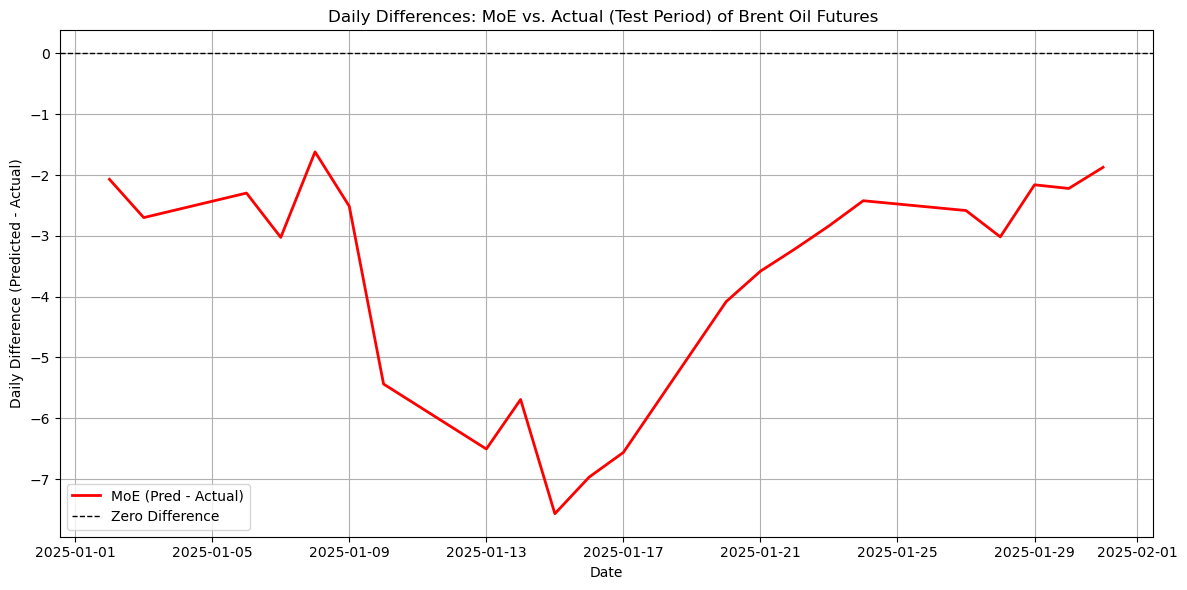

/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/mnt/RFI2/yuzhe/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.

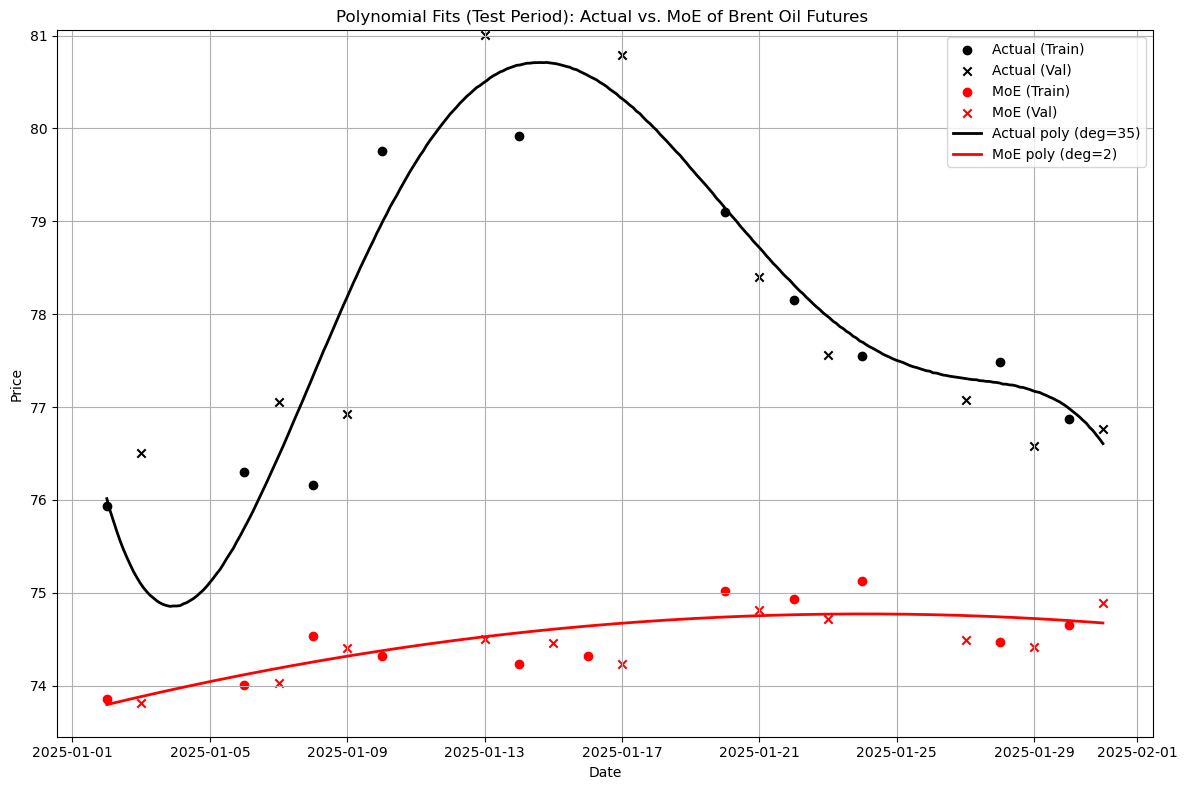


=== Best Polynomial Fitting Results ===
Actual: deg=35, Val MSE=0.625878
  y = -1.37e-138*x^35-4.25e-135*x^34+1.97e-130*x^33+6.72e-126*x^32+1.45e-121*x^31+2.53e-117*x^30+3.51e-113*x^29+3.44e-109*x^28-1.37e-105*x^27-1.63e-100*x^26-5.58e-96*x^25-1.43e-91*x^24-3.19e-87*x^23-6.35e-83*x^22-1.14e-78*x^21-1.8e-74*x^20-2.27e-70*x^19-1.62e-66*x^18+3.27e-62*x^17+1.87e-57*x^16+5.89e-53*x^15+1.49e-48*x^14+3.39e-44*x^13+6.91e-40*x^12+1.26e-35*x^11+2.01e-31*x^10+2.35e-27*x^9+7.99e-24*x^8-7.52e-19*x^7-3.35e-14*x^6-9.72e-10*x^5-2.25e-05*x^4-0.422*x^3-5.11e+03*x^2+4.05e+07*x+5.74e+12
MoE: deg=2, Val MSE=0.042710
  y = -0.00201*x^2+80.8*x-8.12e+05

===== MoE Model Trade Log =====
Flat(ignored) | 2025-01-02 -> 2025-01-02 (1 days) | Entry=75.93, Exit=75.93, AbsDiff=0.00 | Ret=0.00% | EndCap=100.00
Flat(ignored) | 2025-01-03 -> 2025-01-03 (1 days) | Entry=76.51, Exit=76.51, AbsDiff=0.00 | Ret=0.00% | EndCap=100.00
Flat  | 2025-01-04 -> 2025-01-05 (2 days) | Entry=76.51, Exit=76.51, AbsDiff=0.00 | Ret=0.00

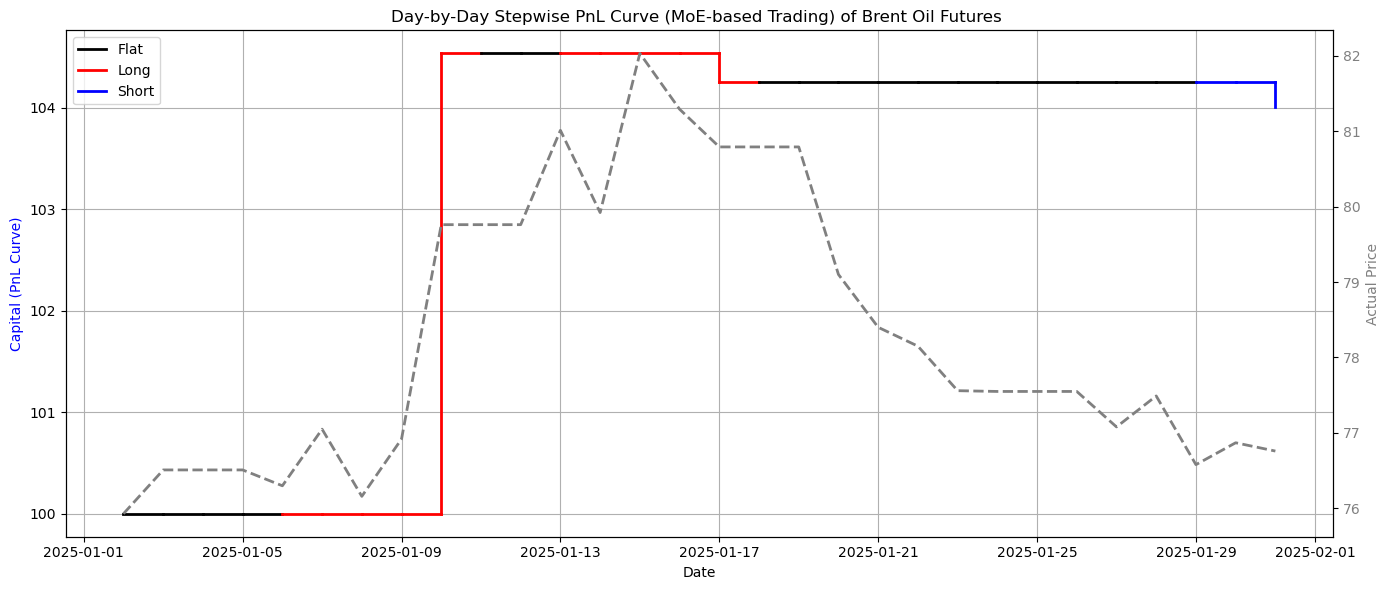

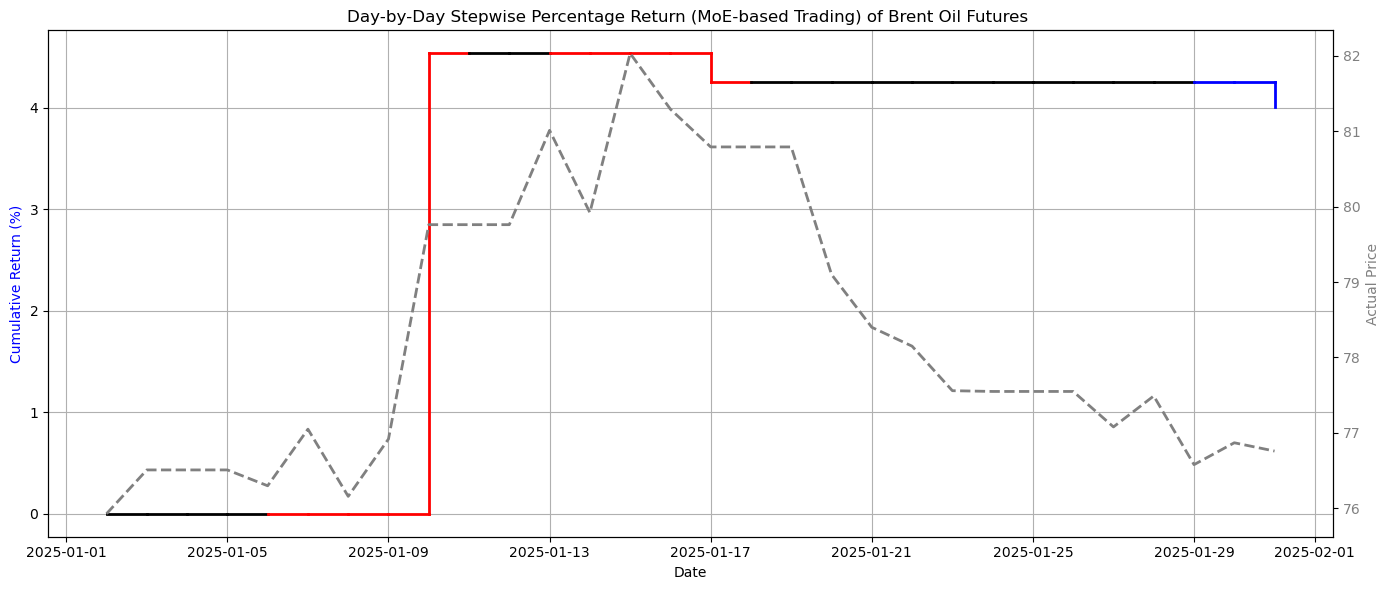

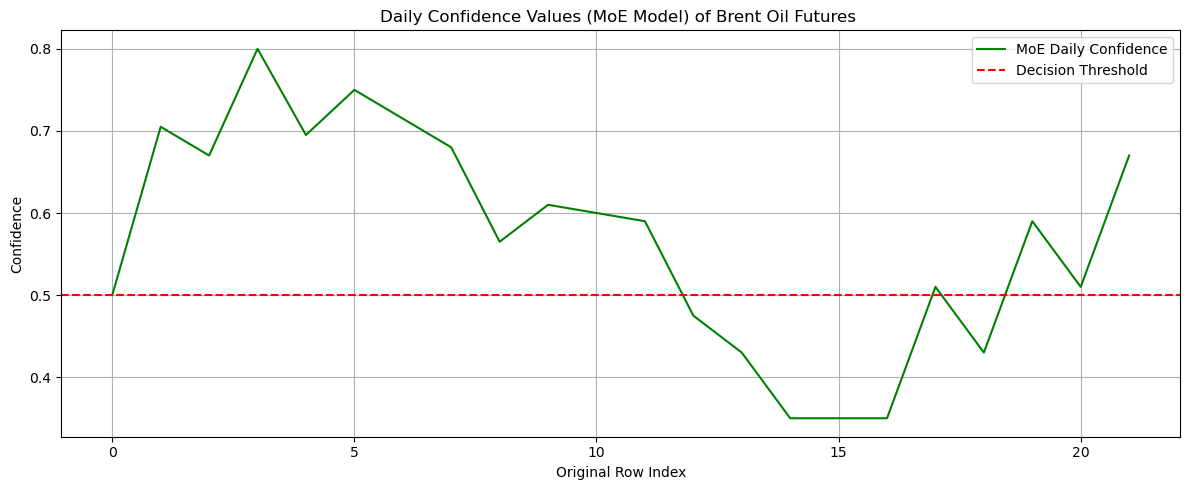


MoE Trading Strategy completed successfully!


In [2]:
##########################################################
# UPDATED CODE: MoE TRADING STRATEGIES (Confidence Voting)
# with Missing-Day => Flat Enforcement
# and Single-Day => Flat(ignored)
##########################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error


##############################################################################
# 1) Load & Plot Daily Difference: MoE vs. Actual
##############################################################################
def plot_moe_daily_difference(df_moe, complete_csv, test_start=pd.to_datetime("2025-01-02")):
    """
    Plots the daily difference (MoE prediction - Actual) in the test period.
      - df_moe must have ["ForecastDate", "MOE_Price"]
      - complete_csv is your final/historical file with actual "Date" + "Price".
      - test_start defines from which date onward we consider 'test' data.
    """
    df_actual = pd.read_csv(complete_csv)
    df_actual["Date"] = pd.to_datetime(df_actual["Date"], errors="coerce")
    df_actual.sort_values("Date", inplace=True)

    # Drop extraneous cols
    for col in ["Vol.", "Change %"]:
        if col in df_actual.columns:
            df_actual.drop(columns=[col], errors="ignore", inplace=True)

    # Clean numeric Price
    if "Price" in df_actual.columns:
        df_actual["Price"] = (
            df_actual["Price"]
            .astype(str)
            .str.replace(",", "", regex=True)
            .astype(float)
        )

    # 2) Focus on test window
    df_test_actual = df_actual[df_actual["Date"] >= test_start].copy()
    df_test_actual.dropna(subset=["Price"], inplace=True)

    # 3) Merge with MoE predictions
    df_moe_ren = df_moe.rename(columns={"ForecastDate": "Date", "MOE_Price": "Pred_MOE"})
    df_merge = pd.merge(df_moe_ren, df_test_actual[["Date", "Price"]],
                        on="Date", how="inner")
    df_merge.sort_values("Date", inplace=True)

    # 4) Compute daily difference
    df_merge["Difference"] = df_merge["Pred_MOE"] - df_merge["Price"]

    # 5) Plot
    plt.figure(figsize=(12,6))
    plt.plot(df_merge["Date"], df_merge["Difference"],
             color="red", linewidth=2, label="MoE (Pred - Actual)")
    plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Difference")
    plt.xlabel("Date")
    plt.ylabel("Daily Difference (Predicted - Actual)")
    plt.title("Daily Differences: MoE vs. Actual (Test Period) of Brent Oil Futures ")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


##############################################################################
# 2) Polynomial Fitting & MoE Trading Strategy
##############################################################################
def polynomial_fitting_moe_trading_strategy(df_moe,
                                            complete_csv,
                                            test_cutoff=pd.to_datetime("2025-01-02"),
                                            max_degree=50):
    """
    1) Merge MoE predictions with actual data (post test_cutoff).
    2) Fit polynomials for (Actual, MoE) using a simple even/odd index approach for train/val.
    3) Plot polynomial fits + derivative curves.
    4) Implement dynamic confidence approach (similar to previous snippets).
    5) Reindex daily, forcing missing-data days => Signal=0.
    6) Piecewise trading simulation => final stepwise PnL + logs.
    """

    # -------------------------------------------------------------------------
    # A) Merge with Actual
    # -------------------------------------------------------------------------
    df_full = pd.read_csv(complete_csv)
    df_full["Date"] = pd.to_datetime(df_full["Date"], errors="coerce")
    df_full.sort_values("Date", inplace=True)
    # Drop extraneous columns
    for col in ["Vol.", "Change %"]:
        if col in df_full.columns:
            df_full.drop(columns=[col], errors="ignore", inplace=True)
    # Clean numeric Price
    if "Price" in df_full.columns:
        df_full["Price"] = (
            df_full["Price"]
            .astype(str)
            .str.replace(",", "", regex=True)
            .astype(float)
        )

    # Filter test period
    df_test_actual = df_full[df_full["Date"] >= test_cutoff].copy()
    df_test_actual = df_test_actual[["Date","Price"]].dropna()

    # Merge
    df_moe_ren = df_moe.rename(columns={"ForecastDate":"Date","MOE_Price":"MoE"})
    df_merged = pd.merge(df_test_actual, df_moe_ren, on="Date", how="inner")
    df_merged.sort_values("Date", inplace=True)
    df_merged.reset_index(drop=True, inplace=True)
    if df_merged.empty:
        print("No overlap between df_moe and actual data. Exiting.")
        return

    df_merged.rename(columns={"Price":"Actual"}, inplace=True)
    df_merged["mdates_num"] = mdates.date2num(df_merged["Date"])

    # -------------------------------------------------------------------------
    # B) Polynomial Fit (Actual vs MoE) with train/val approach
    # -------------------------------------------------------------------------
    columns_to_fit = ["Actual","MoE"]
    n_points = len(df_merged)
    idx_array = np.arange(n_points)
    train_mask = (idx_array % 2 == 0)  # even idx => train
    val_mask   = ~train_mask          # odd idx  => val

    def format_polynomial(coeffs):
        terms = []
        degree = len(coeffs) - 1
        for i, c in enumerate(coeffs):
            power = degree - i
            sign = "+" if c >= 0 else "-"
            if power > 1:
                terms.append(f"{sign}{abs(c):.3g}*x^{power}")
            elif power == 1:
                terms.append(f"{sign}{abs(c):.3g}*x")
            else:
                terms.append(f"{sign}{abs(c):.3g}")
        expr = "".join(terms)
        return expr.lstrip("+").replace("+-","-")

    best_poly = {}
    for col in columns_to_fit:
        x_train = df_merged.loc[train_mask, "mdates_num"].values
        y_train = df_merged.loc[train_mask, col].values
        x_val   = df_merged.loc[val_mask,   "mdates_num"].values
        y_val   = df_merged.loc[val_mask,   col].values

        best_info = {"degree": None, "coeffs": None, "val_mse": float("inf")}
        for deg in range(1, max_degree+1):
            coeffs = np.polyfit(x_train, y_train, deg)
            y_val_pred = np.polyval(coeffs, x_val)
            mse_ = mean_squared_error(y_val, y_val_pred)
            if mse_ < best_info["val_mse"]:
                best_info["degree"] = deg
                best_info["coeffs"] = coeffs
                best_info["val_mse"] = mse_
        best_poly[col] = best_info

    # -------------------------------------------------------------------------
    # C) Plot polynomial fits
    # -------------------------------------------------------------------------
    plt.figure(figsize=(12,8))
    # Plot Actual train vs val
    plt.scatter(df_merged.loc[train_mask,"Date"], df_merged.loc[train_mask,"Actual"],
                color="black", marker="o", label="Actual (Train)")
    plt.scatter(df_merged.loc[val_mask,"Date"], df_merged.loc[val_mask,"Actual"],
                color="black", marker="x", label="Actual (Val)")
    # Plot MoE train vs val
    plt.scatter(df_merged.loc[train_mask,"Date"], df_merged.loc[train_mask,"MoE"],
                color="red", marker="o", label="MoE (Train)")
    plt.scatter(df_merged.loc[val_mask,"Date"], df_merged.loc[val_mask,"MoE"],
                color="red", marker="x", label="MoE (Val)")

    x_dense = np.linspace(df_merged["mdates_num"].min(), df_merged["mdates_num"].max(), 300)
    x_dates = [mdates.num2date(xx) for xx in x_dense]
    color_map = {"Actual":"black","MoE":"red"}

    for col in columns_to_fit:
        deg  = best_poly[col]["degree"]
        coeffs = best_poly[col]["coeffs"]
        y_dense = np.polyval(coeffs, x_dense)
        c_ = color_map.get(col, "gray")
        plt.plot(x_dates, y_dense, color=c_, linewidth=2,
                 label=f"{col} poly (deg={deg})")

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Polynomial Fits (Test Period): Actual vs. MoE of Brent Oil Futures ")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print best polynomials
    print("\n=== Best Polynomial Fitting Results ===")
    for col in columns_to_fit:
        deg  = best_poly[col]["degree"]
        mse  = best_poly[col]["val_mse"]
        expr = format_polynomial(best_poly[col]["coeffs"])
        print(f"{col}: deg={deg}, Val MSE={mse:.6f}")
        print(f"  y = {expr}")

    # -------------------------------------------------------------------------
    # D) Confidence Voting + MoE Trading (same logic, but on poly predictions)
    # -------------------------------------------------------------------------
    # Evaluate polynomial-based MoE
    df_trade = df_merged.copy()
    c_moe = best_poly["MoE"]["coeffs"]
    df_trade["MoE_poly_pred"] = np.polyval(c_moe, df_trade["mdates_num"])

    # Set up dynamic confidences
    w_static = 0.25
    w_fit    = 0.35
    w_grad   = 0.40

    dyn_static_conf = 0.5
    dyn_fit_conf    = 0.5
    dyn_grad_conf   = 0.5

    alpha_static_up   = 0.2
    alpha_static_down = 0.1
    alpha_fit_up      = 0.2
    alpha_fit_down    = 0.1
    alpha_grad_up     = 0.4
    alpha_grad_down   = 0.2

    fit_threshold     = 1.0
    static_threshold  = 1.0
    threshold         = 0.5

    consecutive_all_wrong = 0
    MAX_CONSECUTIVE_ALL_WRONG = 2

    signals = np.zeros(len(df_trade), dtype=int)
    conf_vals = np.zeros(len(df_trade), dtype=float)

    def re_normalize(*args):
        s = sum(args)
        if abs(s) < 1e-9:
            return [1/len(args)]*len(args)
        return [a/s for a in args]

    for i in range(len(df_trade)):
        if i == 0:
            signals[i] = 0
            conf_vals[i] = (dyn_static_conf + dyn_fit_conf + dyn_grad_conf) / 3.0
            continue

        # Day-to-day changes
        moe_change = df_trade.loc[i, "MoE_poly_pred"] - df_trade.loc[i-1, "MoE_poly_pred"]
        act_change = df_trade.loc[i, "Actual"]        - df_trade.loc[i-1, "Actual"]
        err = abs(moe_change - act_change)

        # Update fit confidence
        if err < fit_threshold:
            dyn_fit_conf += alpha_fit_up
        else:
            dyn_fit_conf -= alpha_fit_down
        dyn_fit_conf = np.clip(dyn_fit_conf, 0, 1)

        # Update gradient confidence
        moe_sign = np.sign(moe_change)
        act_sign = np.sign(act_change)
        if moe_sign == act_sign:
            dyn_grad_conf += alpha_grad_up
        else:
            dyn_grad_conf -= alpha_grad_down
        dyn_grad_conf = np.clip(dyn_grad_conf, 0, 1)

        # Update static confidence
        direct_err = abs(df_trade.loc[i, "MoE_poly_pred"] - df_trade.loc[i, "Actual"])
        if direct_err < static_threshold:
            dyn_static_conf += alpha_static_up
        else:
            dyn_static_conf -= alpha_static_down
        dyn_static_conf = np.clip(dyn_static_conf, 0, 1)

        # Combine
        w_st, w_ft, w_gr = re_normalize(w_static, w_fit, w_grad)
        total_conf = (dyn_static_conf*w_st
                      + dyn_fit_conf*w_ft
                      + dyn_grad_conf*w_gr)
        conf_vals[i] = total_conf

        # Weighted directional vote
        if moe_sign != act_sign:
            consecutive_all_wrong += 1
        else:
            consecutive_all_wrong = 0

        combined_vote = total_conf * moe_sign
        if combined_vote >= threshold:
            signals[i] = 1
        elif combined_vote <= -threshold:
            signals[i] = -1
        else:
            signals[i] = 0

        # If too many consecutive errors, flip signal
        if consecutive_all_wrong > MAX_CONSECUTIVE_ALL_WRONG:
            signals[i] = -signals[i]

    df_trade["Signal"] = signals

    # -------------------------------------------------------------------------
    # E) Enforce "missing" days => Flat
    #    (i.e. if the day did not exist in the original, we set Signal=0)
    # -------------------------------------------------------------------------
    original_dates = set(df_trade["Date"])  # store now before reindex

    # Now do daily reindex with forward-fill
    df_trade.set_index("Date", inplace=True)
    df_trade = df_trade.asfreq("D", method="ffill")

    # Tag which are newly inserted rows
    df_trade["IsInserted"] = ~df_trade.index.isin(original_dates)
    # Force any inserted row => Signal=0
    df_trade.loc[df_trade["IsInserted"] == True, "Signal"] = 0

    df_trade.reset_index(inplace=True)
    df_trade.rename(columns={"index":"Date"}, inplace=True)

    # -------------------------------------------------------------------------
    # F) Piecewise Trading Simulation
    # -------------------------------------------------------------------------
    def get_segments(df_local, signal_col="Signal"):
        segs = []
        start_idx = 0
        curr_sig = df_local.loc[0, signal_col]
        for idx in range(1, len(df_local)):
            if df_local.loc[idx, signal_col] != curr_sig:
                segs.append((start_idx, idx-1, curr_sig))
                start_idx=idx
                curr_sig=df_local.loc[idx, signal_col]
        segs.append((start_idx, len(df_local)-1, curr_sig))
        return segs

    def piecewise_trading_simulation_offset(df_sim, start_cap=100.0):
        """
        Stepwise trades with offset settlement:
        - Start capital = 100
        - Realize PnL at segment's end
        - If seg_days < 2 => forcibly treat that as Flat (no real position),
            and overwrite the signal in the DataFrame to 0 for that day.
        """
        segments = get_segments(df_sim, "Signal")
        capital = start_cap
        cap_arr = np.zeros(len(df_sim))
        trade_log = []

        for (start, end, sig) in segments:
            seg_days = end - start + 1
            start_dt = df_sim.loc[start, "Date"]
            end_dt   = df_sim.loc[end,   "Date"]

            # Keep the capital stable through the segment
            for i in range(start, end + 1):
                cap_arr[i] = capital

            # A) If the segment is <2 days, force it to Flat
            if seg_days < 2:
                # Overwrite signals in df to 0 for that day
                df_sim.loc[start:end, "Signal"] = 0

                trade_log.append({
                    "Signal": "Flat(ignored)",
                    "StartDate": start_dt,
                    "EndDate": end_dt,
                    "Days": seg_days,
                    "EntryPrice": df_sim.loc[start, "Actual"],
                    "ExitPrice":  df_sim.loc[end,   "Actual"],
                    "AbsDiff": 0.0,
                    "SegmentReturn(%)": 0.0,
                    "EndCapital": capital
                })
                continue

            # B) Otherwise, do normal multi‐day trade settlement
            if sig == 0:
                # Multi-day flat
                trade_log.append({
                    "Signal": "Flat",
                    "StartDate": start_dt,
                    "EndDate": end_dt,
                    "Days": seg_days,
                    "EntryPrice": df_sim.loc[start, "Actual"],
                    "ExitPrice":  df_sim.loc[end,   "Actual"],
                    "AbsDiff": abs(df_sim.loc[end, "Actual"] - df_sim.loc[start, "Actual"]),
                    "SegmentReturn(%)": 0.0,
                    "EndCapital": capital
                })

            elif sig == 1:
                # Long
                entry_p = df_sim.loc[start, "Actual"]
                exit_p  = df_sim.loc[end,   "Actual"]
                final_c = capital * (exit_p / entry_p)
                seg_ret = (final_c / capital) - 1.0

                cap_arr[end] = final_c
                capital = final_c

                trade_log.append({
                    "Signal": "Long",
                    "StartDate": start_dt,
                    "EndDate": end_dt,
                    "Days": seg_days,
                    "EntryPrice": entry_p,
                    "ExitPrice":  exit_p,
                    "AbsDiff": abs(exit_p - entry_p),
                    "SegmentReturn(%)": seg_ret * 100.0,
                    "EndCapital": final_c
                })

            else:
                # Short
                entry_p = df_sim.loc[start, "Actual"]
                exit_p  = df_sim.loc[end,   "Actual"]
                final_c = capital * (entry_p / exit_p)
                seg_ret = (final_c / capital) - 1.0

                cap_arr[end] = final_c
                capital = final_c

                trade_log.append({
                    "Signal": "Short",
                    "StartDate": start_dt,
                    "EndDate": end_dt,
                    "Days": seg_days,
                    "EntryPrice": entry_p,
                    "ExitPrice":  exit_p,
                    "AbsDiff": abs(exit_p - entry_p),
                    "SegmentReturn(%)": seg_ret * 100.0,
                    "EndCapital": final_c
                })

        # Forward‐fill capital for days after last segment
        last_cap = capital
        for i in range(len(df_sim)):
            if cap_arr[i] == 0.0:
                cap_arr[i] = last_cap
            else:
                last_cap = cap_arr[i]

        # Store final arrays
        df_sim["Capital"] = cap_arr
        df_sim["Cumulative_PnL"] = df_sim["Capital"] - start_cap
        df_sim["Cumulative_Return"] = (df_sim["Cumulative_PnL"] / start_cap) * 100.0

        return df_sim, trade_log

    df_trade, trade_log = piecewise_trading_simulation_offset(df_trade)

    # -------------------------------------------------------------------------
    # G) Final Stepwise Charts
    # -------------------------------------------------------------------------
    def plot_piecewise_results_moe(df_local, trade_log_local):
        print("\n===== MoE Model Trade Log =====")
        for trd in trade_log_local:
            print(
                f"{trd['Signal']:5s} | {trd['StartDate'].date()} -> {trd['EndDate'].date()} "
                f"({trd['Days']} days) | "
                f"Entry={trd['EntryPrice']:.2f}, Exit={trd['ExitPrice']:.2f}, "
                f"AbsDiff={trd['AbsDiff']:.2f} | "
                f"Ret={trd['SegmentReturn(%)']:.2f}% | "
                f"EndCap={trd['EndCapital']:.2f}"
            )

        final_cap = df_local["Capital"].iloc[-1]
        final_ret = df_local["Cumulative_Return"].iloc[-1]
        print(f"\nFinal Capital = {final_cap:.2f}, Final Return={final_ret:.2f}%")

        fig, ax1 = plt.subplots(figsize=(14,6))
        color_map_sig = {0:"black", 1:"red", -1:"blue"}
        n_rows = len(df_local)
        for i in range(1,n_rows):
            sig_prev = df_local.loc[i-1,"Signal"]
            x_vals_horiz= [df_local.loc[i-1,"Date"], df_local.loc[i,"Date"]]
            y_vals_horiz= [df_local.loc[i-1,"Capital"], df_local.loc[i-1,"Capital"]]
            ax1.plot(x_vals_horiz, y_vals_horiz,
                     color=color_map_sig[sig_prev], linewidth=2)
            x_vals_vert= [df_local.loc[i,"Date"], df_local.loc[i,"Date"]]
            y_vals_vert= [df_local.loc[i-1,"Capital"], df_local.loc[i,"Capital"]]
            ax1.plot(x_vals_vert, y_vals_vert,
                     color=color_map_sig[sig_prev], linewidth=2)

        ax1.set_xlabel("Date")
        ax1.set_ylabel("Capital (PnL Curve)", color="blue")
        ax1.grid(True)
        ax2 = ax1.twinx()
        ax2.plot(df_local["Date"], df_local["Actual"],
                 color="gray", linestyle="--", linewidth=2)
        ax2.set_ylabel("Actual Price", color="gray")
        ax2.tick_params(axis='y', labelcolor="gray")

        legend_elems = [
            Line2D([0],[0], color='black', lw=2, label='Flat'),
            Line2D([0],[0], color='red',   lw=2, label='Long'),
            Line2D([0],[0], color='blue',  lw=2, label='Short')
        ]
        ax1.legend(handles=legend_elems, loc="upper left")
        ax1.set_title("Day-by-Day Stepwise PnL Curve (MoE-based Trading) of Brent Oil Futures ")
        plt.tight_layout()
        plt.show()

    def plot_piecewise_results_moe_pct(df_local):
        fig, ax1 = plt.subplots(figsize=(14,6))
        color_map_sig = {0:"black", 1:"red", -1:"blue"}
        n_rows = len(df_local)
        for i in range(1,n_rows):
            sig_prev= df_local.loc[i-1,"Signal"]
            x_vals_horiz= [df_local.loc[i-1,"Date"], df_local.loc[i,"Date"]]
            y_vals_horiz= [df_local.loc[i-1,"Cumulative_Return"], df_local.loc[i-1,"Cumulative_Return"]]
            ax1.plot(x_vals_horiz, y_vals_horiz, color=color_map_sig[sig_prev], linewidth=2)
            x_vals_vert= [df_local.loc[i,"Date"], df_local.loc[i,"Date"]]
            y_vals_vert= [df_local.loc[i-1,"Cumulative_Return"], df_local.loc[i,"Cumulative_Return"]]
            ax1.plot(x_vals_vert, y_vals_vert, color=color_map_sig[sig_prev], linewidth=2)

        ax1.set_xlabel("Date")
        ax1.set_ylabel("Cumulative Return (%)", color="blue")
        ax1.grid(True)
        ax2 = ax1.twinx()
        ax2.plot(df_local["Date"], df_local["Actual"],
                 color="gray", linestyle="--", linewidth=2)
        ax2.set_ylabel("Actual Price", color="gray")
        ax2.tick_params(axis='y', labelcolor="gray")
        ax1.set_title("Day-by-Day Stepwise Percentage Return (MoE-based Trading) of Brent Oil Futures ")
        plt.tight_layout()
        plt.show()

    # Show final logs & charts
    plot_piecewise_results_moe(df_trade, trade_log)
    plot_piecewise_results_moe_pct(df_trade)

    # Confidence line
    plt.figure(figsize=(12,5))
    plt.plot(range(len(conf_vals)), conf_vals,
             color="green", label="MoE Daily Confidence")
    plt.axhline(y=threshold, color="red", linestyle="--", label="Decision Threshold")
    plt.title("Daily Confidence Values (MoE Model) of Brent Oil Futures ")
    plt.xlabel("Original Row Index")
    plt.ylabel("Confidence")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nMoE Trading Strategy completed successfully!")


##############################################################################
# EXAMPLE USAGE
##############################################################################
# 1) Plot daily difference
plot_moe_daily_difference(df_moe, "Brent Oil Futures Historical Data_Final Pure Predictions.csv")

# 2) Polynomial fitting + advanced trading strategy
polynomial_fitting_moe_trading_strategy(
    df_moe=df_moe,
    complete_csv="Brent Oil Futures Historical Data_Final Pure Predictions.csv",
    test_cutoff=pd.to_datetime("2025-01-02"),
    max_degree=50
)
